<a href="https://www.kaggle.com/code/krist0phersmith/build-a-custom-rnn-lstm-gru-bidirectional-oh-my?scriptVersionId=133957318" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classifying Disaster Tweets with LSTM's

by Kris Smith

## Problem Statement

This notebook is tackling a [Kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started/overview) wherein the problem is defined in their own words as:

### Competition Description

*Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).*

*But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:*

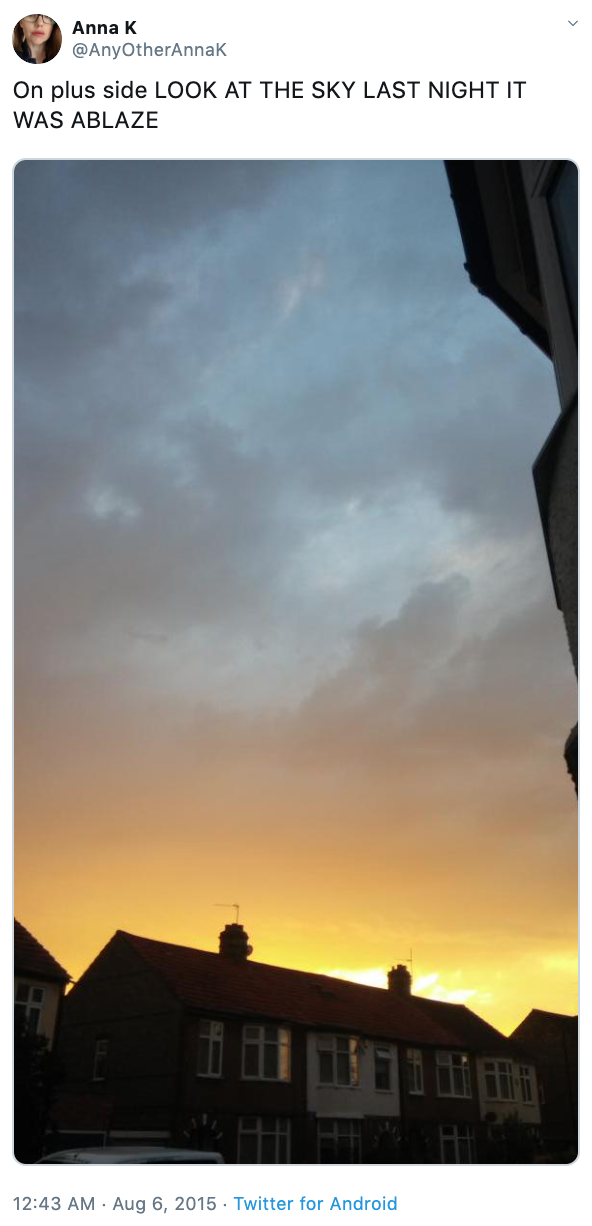

*The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.*

*In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.*

**Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.**

*Acknowledgments
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here.*

*Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480*


### Evaluation

***Competition metric is the F1 score:***

$$
F1 = 2*\frac{precision*recall}{precision+recall}
$$

***where:***

$$
precision = \frac{TP}{TP+FP}
$$

***and:***

$$
recall = \frac{TP}{TP+FN}
$$

***put more simply:***

***True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!***

***False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.***

***False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.***

---
# EDA

## Install/Import Libraries

In [3]:
!pip install pyspellchecker

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, tensorflow as tf
import os
import gc
import re
import string
import operator
import spacy
import nltk
from collections  import defaultdict
from spellchecker import SpellChecker
from tqdm import tqdm
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from IPython.display import Image

stop = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_lg')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from tensorflow import keras
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.layers import Dropout, GlobalAveragePooling1D, SpatialDropout1D, Reshape
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Input
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
# from keras.preprocessing.text import Tokenizer
# from keras.models import Sequential, Model
# from tensorflow.keras.initializers import Constant
# from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

## Set seed for reproducible results
SEED = 112358

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.9 MB/s eta 0:00:0000:0100:01


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Import and Inspect Train and Test Sets

In [4]:
train_path = '../input/nlp-getting-started/train.csv'
test_path  = '../input/nlp-getting-started/test.csv'

# Get the size of the .csv files
train_size = os.path.getsize(train_path)
test_size  = os.path.getsize(test_path)

# Convert the file size to MiB
train_size = round((train_size / 1024**2), 2)
test_size  = round((test_size  / 1024**2), 2)

print(f"Train File size: {train_size} MiB")
print(f"Test File size:  {test_size}  MiB")

df_train = pd.read_csv(train_path, dtype={'id': np.int16, 'target': np.int8})
df_test  = pd.read_csv(test_path,  dtype={'id': np.int16})

print('Training Data Shape = {}'.format(df_train.shape))
print('Test Data Shape = {}'.format(df_test.shape))

Train File size: 0.94 MiB
Test File size:  0.4  MiB
Training Data Shape = (7613, 5)
Test Data Shape = (3263, 4)


***The data seems to be quite minimal which makes sense. This competition on Kaggle was a learning competition and as such had no prize money or actual business attached to it. The means the dataset we are using is somewhat of a 'toy' dataset.***

## Inspect Column Data Types and Counts

In [5]:
print('Training set info')
print('\n')
df_train.info();
print('\n\n\n')
print('Testing set info')
print('\n')
df_test.info()

Training set info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB




Testing set info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int16 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int16(1), object(3)
memory usage: 83.0+ KB


***We can see that the id and target columns are numerical and the keyword, location, and text columns are object type(string). Lets see what the data actually looks like.***

In [6]:
df_train.sample(7, random_state=SEED)

,id,keyword,location,text,target
4149,5898,harm,Kansas City,@dinallyhot Love what you picked! We're playin...,0
2988,4295,drowning,NaN,@Homukami Only URs and SRs matter Rs you'll be...,0
6071,8673,sinkhole,Texas af,Damn that sinkhole on sunset????,1
6720,9627,thunderstorm,"Asheville, NC",iNWS Alert SPSGSP from 8/5/2015 10:40 PM to 11...,1
6656,9539,terrorist,MAD as Hell,RT AbbsWinston: #Zionist #Terrorist kidnapped ...,1
1806,2594,crash,NaN,I see dat we liable to fuck up and crash ????,0
7240,10368,weapons,"Vermont, USA",I think this is my plan for retirement. Check ...,0


## Class Distributions

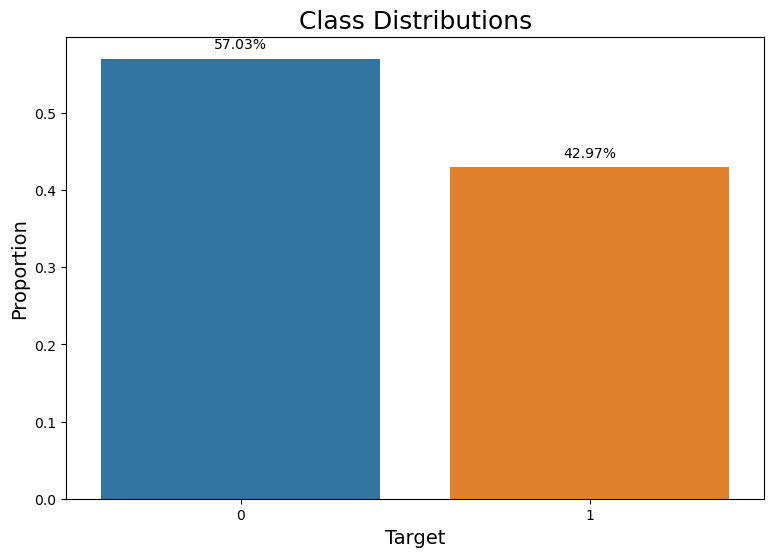

In [7]:
# Calculate the proportions
target_counts = df_train['target'].value_counts(normalize=True).reset_index()

plt.figure(figsize=(9,6))
ax = sns.barplot(data=target_counts, x='index', y='target')

# Add the annotations
for p in ax.patches:
    ax.annotate('{:.2%}'.format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.title('Class Distributions', fontsize=18) 
plt.xlabel('Target', fontsize=14)     
plt.ylabel('Proportion', fontsize=14) 
plt.show()

***So we have a slight class imbalance. At this point I am not sure I wish to do anything about it. We shall see if it may affect any outcomes with model performance.***

## Create NER based features from text column

In [8]:
df_train['num_verbs'] = df_train['text'].apply(lambda row: sum(1 for word, pos in pos_tag(word_tokenize(row)) if pos.startswith('VB')))
df_test['num_verbs']  =  df_test['text'].apply(lambda row: sum(1 for word, pos in pos_tag(word_tokenize(row)) if pos.startswith('VB')))

### Create Verb Count Feature
***Does negative class tweets or positive class tweets contain more verbs than the other?***

In [9]:
print(f"Average number of verbs in negative class tweets = {round(df_train[df_train['target']==0]['num_verbs'].mean(), 3)}")
print(f"Average number of verbs in positive class tweets = {round(df_train[df_train['target']==1]['num_verbs'].mean(), 3)}")
print('\n')
print(f"Negative class tweets on average contain {round(1-(round(df_train[df_train['target']==1]['num_verbs'].mean(), 3)/round(df_train[df_train['target']==0]['num_verbs'].mean(), 3)), 2)}% more verbs.")

Average number of verbs in negative class tweets = 2.385
Average number of verbs in positive class tweets = 2.055


Negative class tweets on average contain 0.14% more verbs.


***It appears that negative class tweets contain more verbs on average than positive class tweets:***

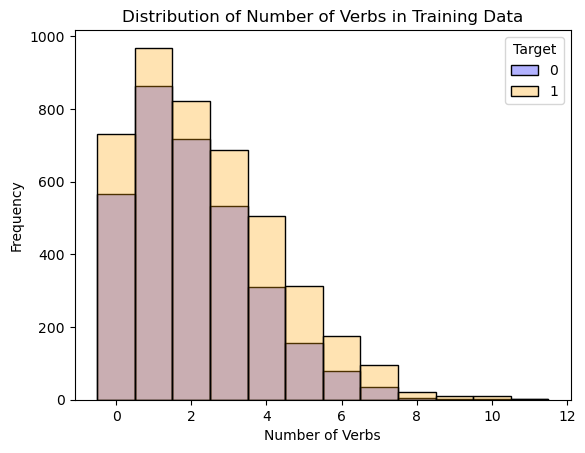

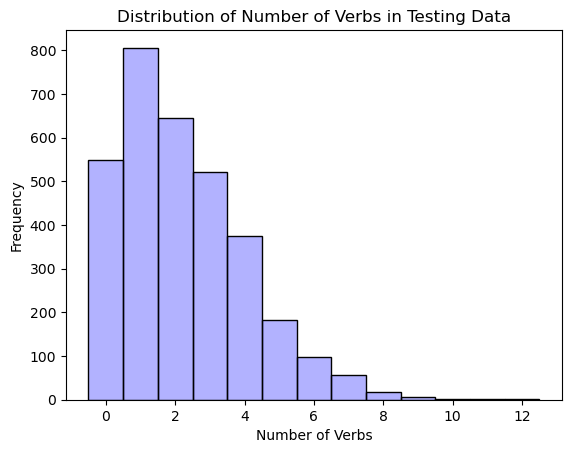

In [10]:
pos, neg = df_train[df_train['target']==1], df_train[df_train['target']==0]

sns.histplot(data=pos, x='num_verbs', discrete=True, multiple="stack", alpha=0.3, color='blue')
sns.histplot(data=neg, x='num_verbs', discrete=True, multiple="stack", alpha=0.3, color='orange')

plt.title('Distribution of Number of Verbs in Training Data') 
plt.xlabel('Number of Verbs')  
plt.ylabel('Frequency')  
plt.legend(title='Target', labels=['0', '1'])  
plt.show()

## Test Data
sns.histplot(data=df_test, x='num_verbs', discrete=True, multiple="stack", alpha=0.3, color='blue')

plt.title('Distribution of Number of Verbs in Testing Data') 
plt.xlabel('Number of Verbs')  
plt.ylabel('Frequency')  
plt.show()

### Create Named Entity Count Feature

In [11]:
df_train['num_entities'] = df_train['text'].apply(lambda row: len([ent for ent in nlp(row).ents]))
df_test['num_entities']  =  df_test['text'].apply(lambda row: len([ent for ent in nlp(row).ents]))

***Does negative class tweets or positive class tweets contain more named entities than the other?***

In [12]:
print(f"Average number of named entities in negative class tweets = {round(df_train[df_train['target']==0]['num_entities'].mean(), 3)}")
print(f"Average number of named entities in positive class tweets = {round(df_train[df_train['target']==1]['num_entities'].mean(), 3)}")
print('\n')
print(f"Positive class tweets on average contain {round(1-(round(df_train[df_train['target']==0]['num_entities'].mean(), 3)/round(df_train[df_train['target']==1]['num_entities'].mean(), 3)), 2)}% more named entities.")

Average number of named entities in negative class tweets = 1.24
Average number of named entities in positive class tweets = 1.96


Positive class tweets on average contain 0.37% more named entities.


***It appears that positive class tweets contain more named entities on average than negative class tweets:***

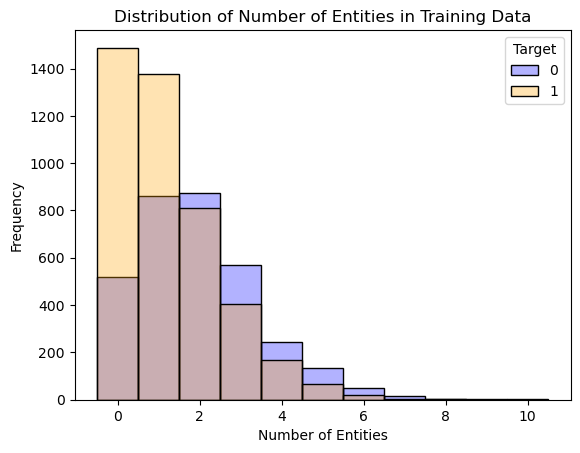

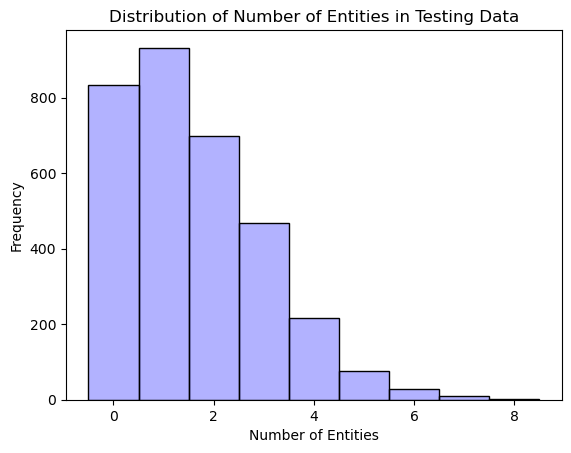

In [13]:
pos, neg = df_train[df_train['target']==1], df_train[df_train['target']==0]

sns.histplot(data=pos, x='num_entities', discrete=True, multiple="stack", alpha=0.3, color='blue')
sns.histplot(data=neg, x='num_entities', discrete=True, multiple="stack", alpha=0.3, color='orange')

plt.title('Distribution of Number of Entities in Training Data') 
plt.xlabel('Number of Entities')  
plt.ylabel('Frequency')  
plt.legend(title='Target', labels=['0', '1'])  
plt.show()

## Test Data
sns.histplot(data=df_test, x='num_entities', discrete=True, multiple="stack", alpha=0.3, color='blue')

plt.title('Distribution of Number of Entities in Testing Data') 
plt.xlabel('Number of Entities')  
plt.ylabel('Frequency')  
plt.show()

### Create Word Count Feature

In [14]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count']  =  df_test['text'].apply(lambda x: len(str(x).split()))

***Does positive class or negative class contain more words on average?***

In [15]:
print(f"Average number of words in negative class tweets = {round(df_train[df_train['target']==0]['word_count'].mean(), 3)}")
print(f"Average number of words in positive class tweets = {round(df_train[df_train['target']==1]['word_count'].mean(), 3)}")
print('\n')
print(f"Positive class tweets on average contain {round(1-(round(df_train[df_train['target']==0]['word_count'].mean(), 3)/round(df_train[df_train['target']==1]['word_count'].mean(), 3)), 2)}% more words.")

Average number of words in negative class tweets = 14.705
Average number of words in positive class tweets = 15.168


Positive class tweets on average contain 0.03% more words.


***The difference in length in words on average for classes seems negligible.***

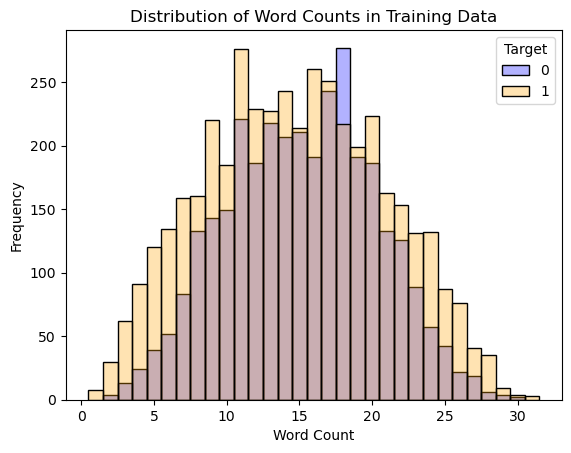

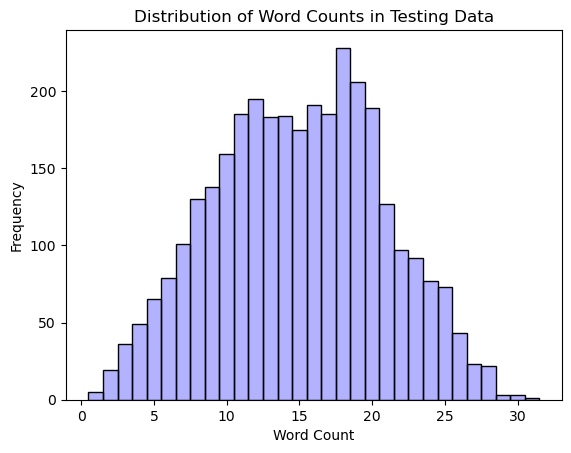

In [16]:
## Training Data
pos, neg = df_train[df_train['target']==1], df_train[df_train['target']==0]

sns.histplot(data=pos, x='word_count', discrete=True, multiple="stack", alpha=0.3, color='blue')
sns.histplot(data=neg, x='word_count', discrete=True, multiple="stack", alpha=0.3, color='orange')

plt.title('Distribution of Word Counts in Training Data') 
plt.xlabel('Word Count')  
plt.ylabel('Frequency')  
plt.legend(title='Target', labels=['0', '1'])  
plt.show()

## Test Data
sns.histplot(data=df_test, x='word_count', discrete=True, multiple="stack", alpha=0.3, color='blue')

plt.title('Distribution of Word Counts in Testing Data') 
plt.xlabel('Word Count')  
plt.ylabel('Frequency')  
plt.show()

## Inspecting Null values

In [17]:
print('Null Proportions Per Column For Training Data')
print(df_train.isna().mean());
print('\n')
print('Null Proportions Per Column For Testing Data')
print(df_test.isna().mean());


Null Proportions Per Column For Training Data
id              0.000000
keyword         0.008013
location        0.332720
text            0.000000
target          0.000000
num_verbs       0.000000
num_entities    0.000000
word_count      0.000000
dtype: float64


Null Proportions Per Column For Testing Data
id              0.000000
keyword         0.007968
location        0.338645
text            0.000000
num_verbs       0.000000
num_entities    0.000000
word_count      0.000000
dtype: float64


***Looking at the distributions of null values and nlp based count features it would appear that the traingin and testing data were from the same sample. This means we might expect the same class imbalance in the testing data for example. Of course there is no way to know this but if we take a pass at inference and it appears to predict similar amounts for each class in the test data as in the training data, and the submission score looks good, then it may be safe to try to optimize this as well as validation F1 score.***

# Pre-Processing

***In order to train our LSTM we must first process the text data so it is in a form that the RNN would like to recieve. We may clean the text by removing stopwords and possibly removing some data where there is null values in important columns which may make our text column of interest less credible for that particular data point.***

***Of course we will also have to convert our text data to tokens and ultimately 'embeddings' to train our model on. A popular pre-trained model for this task is the GloVe embedding model.*** 


## Cleaning Text

In [18]:
## Combine training and test sets to clean them simultaneously
df = pd.concat([df_train, df_test])

### Removing URL's

In [19]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text'] = df['text'].apply(lambda x : remove_URL(x))

### Removing Punctuations
***Reference : https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove***

In [20]:
def remove_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text'] = df['text'].apply(lambda x : remove_punct(x))

### Removing Emoji's

***Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b***

In [21]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text'] = df['text'].apply(lambda x: remove_emoji(x))

### Removing HTML Tags

***Reference: https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove***

In [22]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text'] = df['text'].apply(lambda x : remove_html(x))

### Segment Smashed Multi-Grams

***The following function seperates words which are commonly smashed together in social media text situations. Because of twitters 140 character limit, users have adapted by removing spaces to fit more context into less characters. For example 'I love lamp' can be represented as 'Ilovelamp' which saves the spaces in between so we can fit more words into less characters.***

***We will seperate these out by using a replacement mapping function. The following replacements were taken from part of a function found in the following notebook: https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook#4.-Embeddings-and-Text-Cleaning***

In [23]:
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet, flags=re.I)
    tweet = re.sub(r"\x89ÛÒ", "", tweet, flags=re.I)
    tweet = re.sub(r"\x89ÛÓ", "", tweet, flags=re.I)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet, flags=re.I)
    tweet = re.sub(r"\x89ÛÏ", "", tweet, flags=re.I)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet, flags=re.I)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet, flags=re.I)
    tweet = re.sub(r"\x89Û÷", "", tweet, flags=re.I)
    tweet = re.sub(r"\x89Ûª", "", tweet, flags=re.I)
    tweet = re.sub(r"\x89Û\x9d", "", tweet, flags=re.I)
    tweet = re.sub(r"å_", "", tweet, flags=re.I)
    tweet = re.sub(r"\x89Û¢", "", tweet, flags=re.I)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet, flags=re.I)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet, flags=re.I)
    tweet = re.sub(r"åÊ", "", tweet, flags=re.I)
    tweet = re.sub(r"åÈ", "", tweet, flags=re.I)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet, flags=re.I)    
    tweet = re.sub(r"Ì©", "e", tweet, flags=re.I)
    tweet = re.sub(r"å¨", "", tweet, flags=re.I)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet, flags=re.I)
    tweet = re.sub(r"åÇ", "", tweet, flags=re.I)
    tweet = re.sub(r"å£3million", "3 million", tweet, flags=re.I)
    tweet = re.sub(r"åÀ", "", tweet, flags=re.I)

            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet, flags=re.I)
    tweet = re.sub(r"&lt;", "<", tweet, flags=re.I)
    tweet = re.sub(r"&amp;", "&", tweet, flags=re.I)

    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet, flags=re.I)
    tweet = re.sub(r"w/", "with", tweet, flags=re.I)
    tweet = re.sub(r"USAgov", "USA government", tweet, flags=re.I)
    tweet = re.sub(r"recentlu", "recently", tweet, flags=re.I)
    tweet = re.sub(r"Ph0tos", "Photos", tweet, flags=re.I)
    tweet = re.sub(r"amirite", "am I right", tweet, flags=re.I)
    tweet = re.sub(r"exp0sed", "exposed", tweet, flags=re.I)
    tweet = re.sub(r"<3", "love", tweet, flags=re.I)
    tweet = re.sub(r"amageddon", "armageddon", tweet, flags=re.I)
    tweet = re.sub(r"Trfc", "Traffic", tweet, flags=re.I)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet, flags=re.I)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet, flags=re.I)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet, flags=re.I)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet, flags=re.I)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet, flags=re.I)
    tweet = re.sub(r"16yr", "16 year", tweet, flags=re.I)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet, flags=re.I)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet, flags=re.I)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet, flags=re.I)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet, flags=re.I)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet, flags=re.I) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet, flags=re.I)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet, flags=re.I)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet, flags=re.I)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet, flags=re.I)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet, flags=re.I)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet, flags=re.I)
    tweet = re.sub(r"socialnews", "social news", tweet, flags=re.I)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet, flags=re.I)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet, flags=re.I)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet, flags=re.I)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet, flags=re.I)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet, flags=re.I)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet, flags=re.I)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet, flags=re.I)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet, flags=re.I)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet, flags=re.I)
    tweet = re.sub(r"thankU", "thank you", tweet, flags=re.I)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet, flags=re.I)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet, flags=re.I)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet, flags=re.I)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet, flags=re.I)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet, flags=re.I)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet, flags=re.I)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet, flags=re.I)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet, flags=re.I)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet, flags=re.I)
    tweet = re.sub(r"GodsLove", "God's Love", tweet, flags=re.I)
    tweet = re.sub(r"bookboost", "book boost", tweet, flags=re.I)
    tweet = re.sub(r"ibooklove", "I book love", tweet, flags=re.I)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet, flags=re.I)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet, flags=re.I)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet, flags=re.I)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet, flags=re.I)
    tweet = re.sub(r"weathernetwork", "weather network", tweet, flags=re.I)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet, flags=re.I)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet, flags=re.I)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet, flags=re.I)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet, flags=re.I)
    tweet = re.sub(r"frontpage", "front page", tweet, flags=re.I)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet, flags=re.I)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet, flags=re.I)
    tweet = re.sub(r"til_now", "until now", tweet, flags=re.I)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet, flags=re.I)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet, flags=re.I)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet, flags=re.I)
    tweet = re.sub(r"53inch", "53 inch", tweet, flags=re.I)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet, flags=re.I)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet, flags=re.I)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet, flags=re.I)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet, flags=re.I)
    tweet = re.sub(r"DETECTADO", "Detected", tweet, flags=re.I)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet, flags=re.I)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet, flags=re.I)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet, flags=re.I)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet, flags=re.I)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet, flags=re.I)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet, flags=re.I)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet, flags=re.I)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet, flags=re.I)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet, flags=re.I)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet, flags=re.I)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet, flags=re.I)
    tweet = re.sub(r"Time2015", "Time 2015", tweet, flags=re.I)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet, flags=re.I)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet, flags=re.I)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet, flags=re.I)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet, flags=re.I)
    tweet = re.sub(r"bbcnews", "bbc news", tweet, flags=re.I)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet, flags=re.I)
    tweet = re.sub(r"c4news", "c4 news", tweet, flags=re.I)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet, flags=re.I)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet, flags=re.I)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet, flags=re.I)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet, flags=re.I)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet, flags=re.I)
    tweet = re.sub(r"LondonFire", "London Fire", tweet, flags=re.I)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet, flags=re.I)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet, flags=re.I)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet, flags=re.I)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet, flags=re.I)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet, flags=re.I)
    tweet = re.sub(r"nikeplus", "nike plus", tweet, flags=re.I)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet, flags=re.I)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet, flags=re.I)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet, flags=re.I)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet, flags=re.I)
    tweet = re.sub(r"cnewslive", "C News Live", tweet, flags=re.I)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet, flags=re.I)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet, flags=re.I)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet, flags=re.I)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet, flags=re.I)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet, flags=re.I)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet, flags=re.I)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet, flags=re.I)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet, flags=re.I)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet, flags=re.I)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet, flags=re.I)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet, flags=re.I)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet, flags=re.I)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet, flags=re.I)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet, flags=re.I)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet, flags=re.I)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet, flags=re.I)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet, flags=re.I)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet, flags=re.I)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet, flags=re.I)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet, flags=re.I)
    tweet = re.sub(r"GRupdates", "GR updates", tweet, flags=re.I)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet, flags=re.I)
    tweet = re.sub(r"braininjury", "brain injury", tweet, flags=re.I)
    tweet = re.sub(r"auspol", "Australian politics", tweet, flags=re.I)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet, flags=re.I)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet, flags=re.I)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet, flags=re.I)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet, flags=re.I)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet, flags=re.I)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet, flags=re.I)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet, flags=re.I)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet, flags=re.I)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet, flags=re.I)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet, flags=re.I)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet, flags=re.I)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet, flags=re.I)
    tweet = re.sub(r"offers2go", "offers to go", tweet, flags=re.I)
    tweet = re.sub(r"foodscare", "food scare", tweet, flags=re.I)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet, flags=re.I)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet, flags=re.I)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet, flags=re.I)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet, flags=re.I)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet, flags=re.I)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet, flags=re.I)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet, flags=re.I)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet, flags=re.I)
    tweet = re.sub(r"po_st", "po.st", tweet, flags=re.I)
    tweet = re.sub(r"scoopit", "scoop.it", tweet, flags=re.I)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet, flags=re.I)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet, flags=re.I)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet, flags=re.I)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet, flags=re.I)
    tweet = re.sub(r"OutBid", "outbid", tweet, flags=re.I)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet, flags=re.I)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet, flags=re.I)
    tweet = re.sub(r"15PM", "15 PM", tweet, flags=re.I)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet, flags=re.I)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet, flags=re.I)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet, flags=re.I)
    tweet = re.sub(r"RT_America", "RT America", tweet, flags=re.I)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet, flags=re.I)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet, flags=re.I)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet, flags=re.I)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet, flags=re.I)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet, flags=re.I)
    tweet = re.sub(r"gunsense", "gun sense", tweet, flags=re.I)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet, flags=re.I)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet, flags=re.I)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet, flags=re.I)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet, flags=re.I)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet, flags=re.I)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet, flags=re.I)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet, flags=re.I)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet, flags=re.I)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet, flags=re.I)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet, flags=re.I)
    tweet = re.sub(r"pdx911", "Portland Police", tweet, flags=re.I)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet, flags=re.I)
    tweet = re.sub(r"Japton", "Arkansas", tweet, flags=re.I)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet, flags=re.I)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet, flags=re.I)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet, flags=re.I)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet, flags=re.I)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet, flags=re.I)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet, flags=re.I)
    tweet = re.sub(r"versethe", "verse the", tweet, flags=re.I)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet, flags=re.I)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet, flags=re.I)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet, flags=re.I)
    tweet = re.sub(r"NANKANA", "Nankana", tweet, flags=re.I)
    tweet = re.sub(r"SAHIB", "Sahib", tweet, flags=re.I)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet, flags=re.I)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet, flags=re.I)
    tweet = re.sub(r"gofundme", "go fund me", tweet, flags=re.I)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet, flags=re.I)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet, flags=re.I)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet, flags=re.I)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet, flags=re.I)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet, flags=re.I)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet, flags=re.I)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet, flags=re.I)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet, flags=re.I)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet, flags=re.I)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet, flags=re.I)
    tweet = re.sub(r"Kowing", "Knowing", tweet, flags=re.I)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet, flags=re.I)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet, flags=re.I)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet, flags=re.I)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet, flags=re.I)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet, flags=re.I)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet, flags=re.I)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet, flags=re.I)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet, flags=re.I)
    tweet = re.sub(r"IndianNews", "Indian News", tweet, flags=re.I)
    tweet = re.sub(r"savebees", "save bees", tweet, flags=re.I)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet, flags=re.I)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet, flags=re.I)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet, flags=re.I)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet, flags=re.I)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet, flags=re.I)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet, flags=re.I)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet, flags=re.I)
    tweet = re.sub(r"Daesh", "ISIS", tweet, flags=re.I)
    tweet = re.sub(r"s2g", "swear to god", tweet, flags=re.I)
    tweet = re.sub(r"listenlive", "listen live", tweet, flags=re.I)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet, flags=re.I)
    tweet = re.sub(r"FoxNew", "Fox News", tweet, flags=re.I)
    tweet = re.sub(r"FoxNews", "Fox News", tweet, flags=re.I)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet, flags=re.I)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet, flags=re.I)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet, flags=re.I)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet, flags=re.I)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet, flags=re.I)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet, flags=re.I)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet, flags=re.I)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet, flags=re.I)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet, flags=re.I)
    tweet = re.sub(r"PINER", "Piner", tweet, flags=re.I)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet, flags=re.I)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet, flags=re.I)
    tweet = re.sub(r"residualincome", "residual income", tweet, flags=re.I)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet, flags=re.I)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet, flags=re.I)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet, flags=re.I)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet, flags=re.I)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet, flags=re.I)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet, flags=re.I)
    tweet = re.sub(r"pop2015", "pop 2015", tweet, flags=re.I)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet, flags=re.I)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet, flags=re.I)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet, flags=re.I)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet, flags=re.I)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet, flags=re.I)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet, flags=re.I)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet, flags=re.I)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet, flags=re.I)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet, flags=re.I)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet, flags=re.I)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet, flags=re.I)
    tweet = re.sub(r"Latestnews", "Latest news", tweet, flags=re.I)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet, flags=re.I)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet, flags=re.I)
    tweet = re.sub(r"datingtips", "dating tips", tweet, flags=re.I)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet, flags=re.I)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet, flags=re.I)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet, flags=re.I)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet, flags=re.I)
    tweet = re.sub(r"Newss", "News", tweet, flags=re.I)
    tweet = re.sub(r"hempoil", "hemp oil", tweet, flags=re.I)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet, flags=re.I)
    tweet = re.sub(r"tubestrike", "tube strike", tweet, flags=re.I)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet, flags=re.I)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet, flags=re.I)
    tweet = re.sub(r"TI5", "The International 5", tweet, flags=re.I)
    tweet = re.sub(r"thehill", "the hill", tweet, flags=re.I)
    tweet = re.sub(r"3others", "3 others", tweet, flags=re.I)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet, flags=re.I)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet, flags=re.I)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet, flags=re.I)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet, flags=re.I)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet, flags=re.I)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet, flags=re.I)
    tweet = re.sub(r"andword", "and word", tweet, flags=re.I)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet, flags=re.I)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet, flags=re.I)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet, flags=re.I)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet, flags=re.I)
    tweet = re.sub(r"57am", "57 am", tweet, flags=re.I)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet, flags=re.I)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet, flags=re.I)
    tweet = re.sub(r"newnewnew", "new new new", tweet, flags=re.I)
    tweet = re.sub(r"under50", "under 50", tweet, flags=re.I)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet, flags=re.I)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet, flags=re.I)
    tweet = re.sub(r"amwriting", "am writing", tweet, flags=re.I)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet, flags=re.I)
    tweet = re.sub(r"Nowlike", "Now like", tweet, flags=re.I)
    tweet = re.sub(r"seasonfrom", "season from", tweet, flags=re.I)
    tweet = re.sub(r"epicente", "epicenter", tweet, flags=re.I)
    tweet = re.sub(r"epicenterr", "epicenter", tweet, flags=re.I)
    tweet = re.sub(r"sicklife", "sick life", tweet, flags=re.I)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet, flags=re.I)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet, flags=re.I)
    tweet = re.sub(r"approachng", "approaching", tweet, flags=re.I)
    tweet = re.sub(r"evng", "evening", tweet, flags=re.I)
    tweet = re.sub(r"Sumthng", "something", tweet, flags=re.I)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet, flags=re.I)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet, flags=re.I)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet, flags=re.I)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet, flags=re.I)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet, flags=re.I)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet, flags=re.I)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet, flags=re.I)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet, flags=re.I)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet, flags=re.I)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet, flags=re.I)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet, flags=re.I)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet, flags=re.I)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet, flags=re.I)
    tweet = re.sub(r"newauthors", "new authors", tweet, flags=re.I)
    tweet = re.sub(r"remedyyyy", "remedy", tweet, flags=re.I)
    tweet = re.sub(r"44PM", "44 PM", tweet, flags=re.I)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet, flags=re.I)
    tweet = re.sub(r"40PM", "40 PM", tweet, flags=re.I)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet, flags=re.I)
    tweet = re.sub(r"ithats", "that is", tweet, flags=re.I)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet, flags=re.I)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet, flags=re.I)
    tweet = re.sub(r"02PM", "02 PM", tweet, flags=re.I)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet, flags=re.I)
    tweet = re.sub(r"Bstrd", "bastard", tweet, flags=re.I)
    tweet = re.sub(r"bldy", "bloody", tweet, flags=re.I)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet, flags=re.I)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet, flags=re.I)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet, flags=re.I)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet, flags=re.I)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet, flags=re.I)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet, flags=re.I)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet, flags=re.I)
    tweet = re.sub(r"incubusband", "incubus band", tweet, flags=re.I)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet, flags=re.I)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet, flags=re.I)
    tweet = re.sub(r"win10", "Windows 10", tweet, flags=re.I)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet, flags=re.I)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet, flags=re.I)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet, flags=re.I)
    tweet = re.sub(r"crewlist", "crew list", tweet, flags=re.I)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet, flags=re.I)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet, flags=re.I)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet, flags=re.I)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet, flags=re.I)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet, flags=re.I)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet, flags=re.I)
    tweet = re.sub(r"pctool", "pc tool", tweet, flags=re.I)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet, flags=re.I)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet, flags=re.I)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet, flags=re.I)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet, flags=re.I)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet, flags=re.I)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet, flags=re.I)
    tweet = re.sub(r"writerslife", "writers life", tweet, flags=re.I)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet, flags=re.I)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet, flags=re.I)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet, flags=re.I)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet, flags=re.I)
    tweet = re.sub(r"vscodc", "vsco DC", tweet, flags=re.I)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet, flags=re.I)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet, flags=re.I)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet, flags=re.I)
    tweet = re.sub(r"WorldOil", "World Oil", tweet, flags=re.I)
    tweet = re.sub(r"redwedding", "red wedding", tweet, flags=re.I)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet, flags=re.I)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet, flags=re.I)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet, flags=re.I)
    tweet = re.sub(r"bleased", "blessed", tweet, flags=re.I)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet, flags=re.I)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet, flags=re.I)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet, flags=re.I)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet, flags=re.I)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet, flags=re.I)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet, flags=re.I)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet, flags=re.I)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet, flags=re.I)
    tweet = re.sub(r"changetheworld", "change the world", tweet, flags=re.I)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet, flags=re.I)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet, flags=re.I)
    tweet = re.sub(r"withweapons", "with weapons", tweet, flags=re.I)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet, flags=re.I)
    tweet = re.sub(r"letsFootball", "let us Football", tweet, flags=re.I)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet, flags=re.I)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet, flags=re.I)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet, flags=re.I)
    tweet = re.sub(r"22PM", "22 PM", tweet, flags=re.I)
    tweet = re.sub(r"54am", "54 AM", tweet, flags=re.I)
    tweet = re.sub(r"38am", "38 AM", tweet, flags=re.I)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet, flags=re.I)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet, flags=re.I)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet, flags=re.I)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet, flags=re.I)
    tweet = re.sub(r"2k15", "2015", tweet, flags=re.I)
    tweet = re.sub(r"TheIran", "Iran", tweet, flags=re.I)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet, flags=re.I)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet, flags=re.I)
    tweet = re.sub(r"defense_news", "defense news", tweet, flags=re.I)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet, flags=re.I)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet, flags=re.I)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet, flags=re.I)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet, flags=re.I)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet, flags=re.I)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet, flags=re.I)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet, flags=re.I)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet, flags=re.I)
    tweet = re.sub(r"toopainful", "too painful", tweet, flags=re.I)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet, flags=re.I)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet, flags=re.I)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet, flags=re.I)
    tweet = re.sub(r"ineedcake", "I need cake", tweet, flags=re.I)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet, flags=re.I)
    tweet = re.sub(r"BBCOne", "BBC One", tweet, flags=re.I)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet, flags=re.I)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet, flags=re.I)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet, flags=re.I)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet, flags=re.I)
    tweet = re.sub(r"irongiant", "iron giant", tweet, flags=re.I)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet, flags=re.I)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet, flags=re.I)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet, flags=re.I)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet, flags=re.I)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet, flags=re.I)
    tweet = re.sub(r"concertphotography", "concert photography", tweet, flags=re.I)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet, flags=re.I)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet, flags=re.I)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet, flags=re.I)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet, flags=re.I)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet, flags=re.I)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet, flags=re.I)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet, flags=re.I)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet, flags=re.I)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet, flags=re.I)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet, flags=re.I)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet, flags=re.I)
    tweet = re.sub(r"NotSorry", "not sorry", tweet, flags=re.I)
    tweet = re.sub(r"UseYourWords", "use your words", tweet, flags=re.I)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet, flags=re.I)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet, flags=re.I)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet, flags=re.I)
    tweet = re.sub(r"jokethey", "joke they", tweet, flags=re.I)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet, flags=re.I)
    tweet = re.sub(r"uiseful", "useful", tweet, flags=re.I)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet, flags=re.I)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet, flags=re.I)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet, flags=re.I)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet, flags=re.I)
    tweet = re.sub(r"birdgang", "bird gang", tweet, flags=re.I)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet, flags=re.I)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet, flags=re.I)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet, flags=re.I)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet, flags=re.I)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet, flags=re.I)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet, flags=re.I)
    tweet = re.sub(r"hegot", "he got", tweet, flags=re.I)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet, flags=re.I)
    tweet = re.sub(r"sothathappened", "so that happened", tweet, flags=re.I)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet, flags=re.I)
    tweet = re.sub(r"NationFirst", "Nation First", tweet, flags=re.I)
    tweet = re.sub(r"IndiaToday", "India Today", tweet, flags=re.I)
    tweet = re.sub(r"HLPS", "helps", tweet, flags=re.I)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet, flags=re.I)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet, flags=re.I)
    tweet = re.sub(r"BidTime", "Bid Time", tweet, flags=re.I)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet, flags=re.I)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet, flags=re.I)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet, flags=re.I)
    tweet = re.sub(r"eatshit", "eat shit", tweet, flags=re.I)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet, flags=re.I)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet, flags=re.I)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet, flags=re.I)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet, flags=re.I)
    tweet = re.sub(r"facilitydude", "facility dude", tweet, flags=re.I)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet, flags=re.I)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet, flags=re.I)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet, flags=re.I)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet, flags=re.I)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet, flags=re.I)
    tweet = re.sub(r"yychail", "Calgary hail", tweet, flags=re.I)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet, flags=re.I)
    tweet = re.sub(r"eliotschool", "eliot school", tweet, flags=re.I)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet, flags=re.I)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet, flags=re.I)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet, flags=re.I)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet, flags=re.I)
    tweet = re.sub(r"IranElection", "Iran Election", tweet, flags=re.I)
    tweet = re.sub(r"glowng", "glowing", tweet, flags=re.I)
    tweet = re.sub(r"kindlng", "kindling", tweet, flags=re.I)
    tweet = re.sub(r"riggd", "rigged", tweet, flags=re.I)
    tweet = re.sub(r"slownewsday", "slow news day", tweet, flags=re.I)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet, flags=re.I)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet, flags=re.I)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet, flags=re.I)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet, flags=re.I)
    tweet = re.sub(r"netbots", "net bots", tweet, flags=re.I)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet, flags=re.I)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet, flags=re.I)
    tweet = re.sub(r"EndofUS", "End of United States", tweet, flags=re.I)
    tweet = re.sub(r"35PM", "35 PM", tweet, flags=re.I)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet, flags=re.I)
    tweet = re.sub(r"76mins", "76 minutes", tweet, flags=re.I)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet, flags=re.I)
    tweet = re.sub(r"livesmatter", "lives matter", tweet, flags=re.I)
    tweet = re.sub(r"myhometown", "my hometown", tweet, flags=re.I)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet, flags=re.I)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet, flags=re.I)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet, flags=re.I)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet, flags=re.I)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet, flags=re.I)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet, flags=re.I)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet, flags=re.I)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet, flags=re.I)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet, flags=re.I)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet, flags=re.I)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet, flags=re.I)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet, flags=re.I)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet, flags=re.I)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet, flags=re.I)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet, flags=re.I)
    tweet = re.sub(r"kostumes", "costumes", tweet, flags=re.I)
    tweet = re.sub(r"YEEESSSS", "yes", tweet, flags=re.I)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet, flags=re.I)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet, flags=re.I)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet, flags=re.I)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet, flags=re.I)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet, flags=re.I)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet, flags=re.I)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet, flags=re.I)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet, flags=re.I)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet, flags=re.I)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet, flags=re.I)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet, flags=re.I)
    tweet = re.sub(r"FromTheField", "From the field", tweet, flags=re.I)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet, flags=re.I)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet, flags=re.I)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet, flags=re.I)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet, flags=re.I)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet, flags=re.I)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet, flags=re.I)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet, flags=re.I)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet, flags=re.I)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet, flags=re.I)
    tweet = re.sub(r"Evaucation", "evacuation", tweet, flags=re.I)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet, flags=re.I)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet, flags=re.I)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet, flags=re.I)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet, flags=re.I)
    tweet = re.sub(r"localplumber", "local plumber", tweet, flags=re.I)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet, flags=re.I)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet, flags=re.I)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet, flags=re.I)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet, flags=re.I)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet, flags=re.I)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet, flags=re.I)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet, flags=re.I)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet, flags=re.I)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet, flags=re.I)
    tweet = re.sub(r"wfocus", "focus", tweet, flags=re.I)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet, flags=re.I)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet, flags=re.I)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet, flags=re.I)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet, flags=re.I)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet, flags=re.I)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet, flags=re.I)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet, flags=re.I)
    tweet = re.sub(r"bedhair", "bed hair", tweet, flags=re.I)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet, flags=re.I)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet, flags=re.I)
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet, flags=re.I)
    tweet = re.sub(r"mÌ¼sica", "music", tweet, flags=re.I)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet, flags=re.I)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet, flags=re.I)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet, flags=re.I)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet, flags=re.I)  
    tweet = re.sub(r"cawx", "California Weather", tweet, flags=re.I)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet, flags=re.I)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet, flags=re.I)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet, flags=re.I)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet, flags=re.I)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet, flags=re.I)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet, flags=re.I)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet, flags=re.I)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet, flags=re.I)
    
    return(tweet)


df['text'] = df['text'].apply(lambda s : clean(s))

### Spell Check and Correct

In [24]:
## Ensure all text samples are string type
df['text'] = df['text'].astype(str)

In [25]:
spell = SpellChecker()

def spell_check(text):
    corrected_text = []
    if text is not None:
        misspelled_words = spell.unknown(text.split())
        for word in text.split():
            if word in misspelled_words:
                corrected_word = spell.correction(word)
            else:
                corrected_word = word
            # explicitly convert to string
            corrected_text.append(str(corrected_word))
        return " ".join(corrected_text)
    else:
#         return('')  # return None if text is None, or we could return an empty string: ''
        return(None)  # return None if text is None, or we could return an empty string: ''

    
df['text'] = df['text'].apply(spell_check)

### Load GloVe Text Embeddings

***What are word embeddings? These are vector representations of words. The embedding corpus is simply a hash table(python dict in this case) which consists of a number of words(keys) and their corresponding vector representation(values).***

***GLoVe embeddings come in various sizes. I am using the larger version which is 300 dimensional array.***

In [26]:
glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)

***Confirm each word embedding vector is of dimension 300:***

In [27]:
## Display the embeddings for the word 'the'
print(f"Total Number of Words In GLoVe Embeddings = {len(glove_embeddings)}")

## Check array size for a word to confirm it is size 300
dimensions = len(glove_embeddings['the'])

print(f"Total Dimension Size for Each Words Vector Representation = {dimensions}")

Total Number of Words In GLoVe Embeddings = 2196008
Total Dimension Size for Each Words Vector Representation = 300


***Wow, this particular word embedding corpus(GLoVe) contains `2,196,008` unique N-gram vector representations!. We have also confirmed that each vector representation is of dimension `300d`.***

### Create Text Corpus and Clean Stop Words

In [28]:
corpus = []
for tweet in tqdm(df['text']):
    words = [word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
    corpus.append(words)

100%|██████████| 10876/10876 [00:02<00:00, 5200.55it/s]


In [29]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)

MAX_LEN = 42 ## Max length of tweets is 140 characters, therefore number of tokens does not need to be set very large
sequences = tokenizer_obj.texts_to_sequences(corpus)

processed_tweets = pad_sequences(sequences, 
                          maxlen=MAX_LEN, 
                          padding='post', 
                          truncating='post')

In [30]:
glossary = tokenizer_obj.word_index

print(f'Total Unique Words in Tweet Data = {len(glossary)}')

num_words = (len(glossary) + 1)

Total Unique Words in Tweet Data = 17928


In [31]:
## Initialize empty embedding matrix
embedding_matrix = np.zeros((num_words, dimensions))

## Iterate over glossary and update embedding matrix
for word,i in tqdm(glossary.items()):
    if i > num_words:
        continue
    
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 17928/17928 [00:00<00:00, 234304.93it/s]


***Lets confirm our embedding matrix is of the dimensions equal to number of unique words and each words vector should be of size 300:***

In [32]:
embedding_matrix.shape

(17929, 300)

***Everything lines up so far!. Lets get to the fun part, designing and building a custom RNN.***

---
# Training

### Isolate Training and Test Sets From Processed Text Corpus

In [33]:
train = processed_tweets[:df_train.shape[0]]
test  = processed_tweets[df_train.shape[0]:]

### Split Training into Train and Validation Sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train, df_train['target'].values, test_size=0.10)

print(f'Number of Training Samples = {len(y_train)}')
print(f'Number of Validation Samples = {len(y_test)}')
print(f'Size of Testing Set = {len(test)}')

Number of Training Samples = 6851
Number of Validation Samples = 762
Size of Testing Set = 3263


### Custom F1 Score Function

In [35]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return(f1_val)

## Design Model Architecture

### Model 1

In [36]:
# with tf.device('/gpu:0'):  
#     model = Sequential()

#     ## Embedding Layer:
#     ## Takes each word in the sequence and turns it into a dense vector of fixed size. 
#     ## The output of this layer is a 2D vector where the first dimension is the sequence,
#     ## and the second dimension is the dense vector representing each word.
#     embedding = Embedding(num_words, 
#                          dimensions, 
#                          input_length=MAX_LEN,
#                          embeddings_initializer=Constant(embedding_matrix), 
#                          trainable=False)

#     model.add(embedding)
    
#     ## Hidden Layers

#     model.add(SpatialDropout1D(0.3))
#     model.add(LSTM(64, return_sequences=True))  # change to return_sequences=True

#     model.add(SpatialDropout1D(0.3))
#     model.add(Bidirectional(LSTM(64, return_sequences=False)))  # LSTM inside Bidirectional outputs a 2D tensor

#     model.add(SpatialDropout1D(0.3))
#     model.add(Dense(64, activation='relu'))  # dense layer
    
#     ## Output Layer (Classification Layer)
#     model.add(Dense(1, activation='sigmoid'))


    
    
#     optimizer = Adam(learning_rate=1e-5)

#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_score])

#     history = model.fit(X_train, 
#                         y_train, 
#                         batch_size=4, 
#                         epochs=5, 
#                         validation_data=(X_test,y_test), 
#                         verbose=2)

### Model 2

In [37]:


# with tf.device('/gpu:0'):  
#     model = Sequential()

#     ## Embedding Layer:
#     ## Takes each word in the sequence and turns it into a dense vector of fixed size. 
#     ## The output of this layer is a 2D vector where the first dimension is the sequence,
#     ## and the second dimension is the dense vector representing each word.
#     embedding = Embedding(num_words, 
#                          dimensions, 
#                          input_length=MAX_LEN,
#                          embeddings_initializer=Constant(embedding_matrix), 
#                          trainable=False)

#     model.add(embedding)
    
#     ## Hidden Layers
#     model.add(Dropout(0.3))  # dropout layer
#     model.add(LSTM(128, return_sequences=True))  # change to return_sequences=True

#     model.add(Dropout(0.3))  # dropout layer
#     model.add(Bidirectional(LSTM(128, return_sequences=False)))  # LSTM inside Bidirectional outputs a 2D tensor

#     model.add(Dropout(0.3))  # dropout layer
#     model.add(Dense(128, activation='relu'))  # dense layer

#     # Adding a Reshape layer to get back to 3D tensor for the next LSTM layer
#     model.add(Reshape((1, 128)))  # this needs to be adjusted based on previous layer output dimensions

#     model.add(Dropout(0.3))  # dropout layer
#     model.add(LSTM(64, return_sequences=True))  # change to return_sequences=True

#     model.add(Dropout(0.3))  # dropout layer
#     model.add(Bidirectional(LSTM(64, return_sequences=False)))  # LSTM inside Bidirectional outputs a 2D tensor

#     model.add(Dropout(0.3))  # dropout layer
#     model.add(Dense(64, activation='relu'))  # dense layer

#     model.add(Dropout(0.3))  # dropout layer
#     ## Output Layer (Classification Layer)
#     model.add(Dense(1, activation='sigmoid'))

    
    
#     optimizer = Adam(learning_rate=1e-5)

#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_score])

#     history = model.fit(X_train, 
#                         y_train, 
#                         batch_size=4, 
#                         epochs=15, 
#                         validation_data=(X_test,y_test), 
#                         verbose=2)


### Model 3

In [43]:
with tf.device('/gpu:0'):  
    model = Sequential()

    ## Embedding Layer:
    ## Takes each word in the sequence and turns it into a dense vector of fixed size. 
    ## The output of this layer is a 2D vector where the first dimension is the sequence,
    ## and the second dimension is the dense vector representing each word.
    embedding = Embedding(num_words, 
                         dimensions, 
                         input_length=MAX_LEN,
                         embeddings_initializer=Constant(embedding_matrix), 
                         trainable=False)

    model.add(embedding)
    
    ## Hidden Layers
    model.add(Dropout(0.3))  # dropout layer
    model.add(LSTM(256, return_sequences=True))  # change to return_sequences=True

    model.add(Dropout(0.3))  # dropout layer
    model.add(Bidirectional(LSTM(256, return_sequences=False)))  # LSTM inside Bidirectional outputs a 2D tensor

    model.add(Dropout(0.3))  # dropout layer
    model.add(Dense(256, activation='relu'))  # dense layer

    # Adding a Reshape layer to get back to 3D tensor for the next LSTM layer
    model.add(Reshape((1, 256)))  # this needs to be adjusted based on previous layer output dimensions
    
    model.add(Dropout(0.3))  # dropout layer
    model.add(LSTM(128, return_sequences=True))  # change to return_sequences=True

    model.add(Dropout(0.3))  # dropout layer
    model.add(Bidirectional(LSTM(128, return_sequences=False)))  # LSTM inside Bidirectional outputs a 2D tensor

    model.add(Dropout(0.3))  # dropout layer
    model.add(Dense(128, activation='relu'))  # dense layer

    model.add(Dropout(0.3))  # dropout layer
    ## Output Layer (Classification Layer)
    model.add(Dense(1, activation='sigmoid'))

    
    
    optimizer = Adam(learning_rate=1e-5)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_score])

    history = model.fit(X_train, 
                        y_train, 
                        batch_size=4, 
                        epochs=14, 
                        validation_data=(X_test,y_test), 
                        verbose=2)


Epoch 1/14
1713/1713 - 41s - loss: 0.6526 - accuracy: 0.6386 - f1_score: 0.2588 - val_loss: 0.5290 - val_accuracy: 0.7769 - val_f1_score: 0.6147 - 41s/epoch - 24ms/step
Epoch 2/14
1713/1713 - 26s - loss: 0.4997 - accuracy: 0.7853 - f1_score: 0.6307 - val_loss: 0.4519 - val_accuracy: 0.8018 - val_f1_score: 0.6086 - 26s/epoch - 15ms/step
Epoch 3/14
1713/1713 - 27s - loss: 0.4610 - accuracy: 0.7993 - f1_score: 0.6274 - val_loss: 0.4231 - val_accuracy: 0.8110 - val_f1_score: 0.6316 - 27s/epoch - 16ms/step
Epoch 4/14
1713/1713 - 26s - loss: 0.4497 - accuracy: 0.8022 - f1_score: 0.6324 - val_loss: 0.4141 - val_accuracy: 0.8163 - val_f1_score: 0.6391 - 26s/epoch - 15ms/step
Epoch 5/14
1713/1713 - 26s - loss: 0.4423 - accuracy: 0.8056 - f1_score: 0.6332 - val_loss: 0.4161 - val_accuracy: 0.8058 - val_f1_score: 0.6390 - 26s/epoch - 15ms/step
Epoch 6/14
1713/1713 - 26s - loss: 0.4300 - accuracy: 0.8102 - f1_score: 0.6408 - val_loss: 0.4039 - val_accuracy: 0.8202 - val_f1_score: 0.6412 - 26s/epoc

## Model Architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 42, 300)           5378700   
                                                                 
 dropout_7 (Dropout)         (None, 42, 300)           0         
                                                                 
 lstm_4 (LSTM)               (None, 42, 256)           570368    
                                                                 
 dropout_8 (Dropout)         (None, 42, 256)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                      

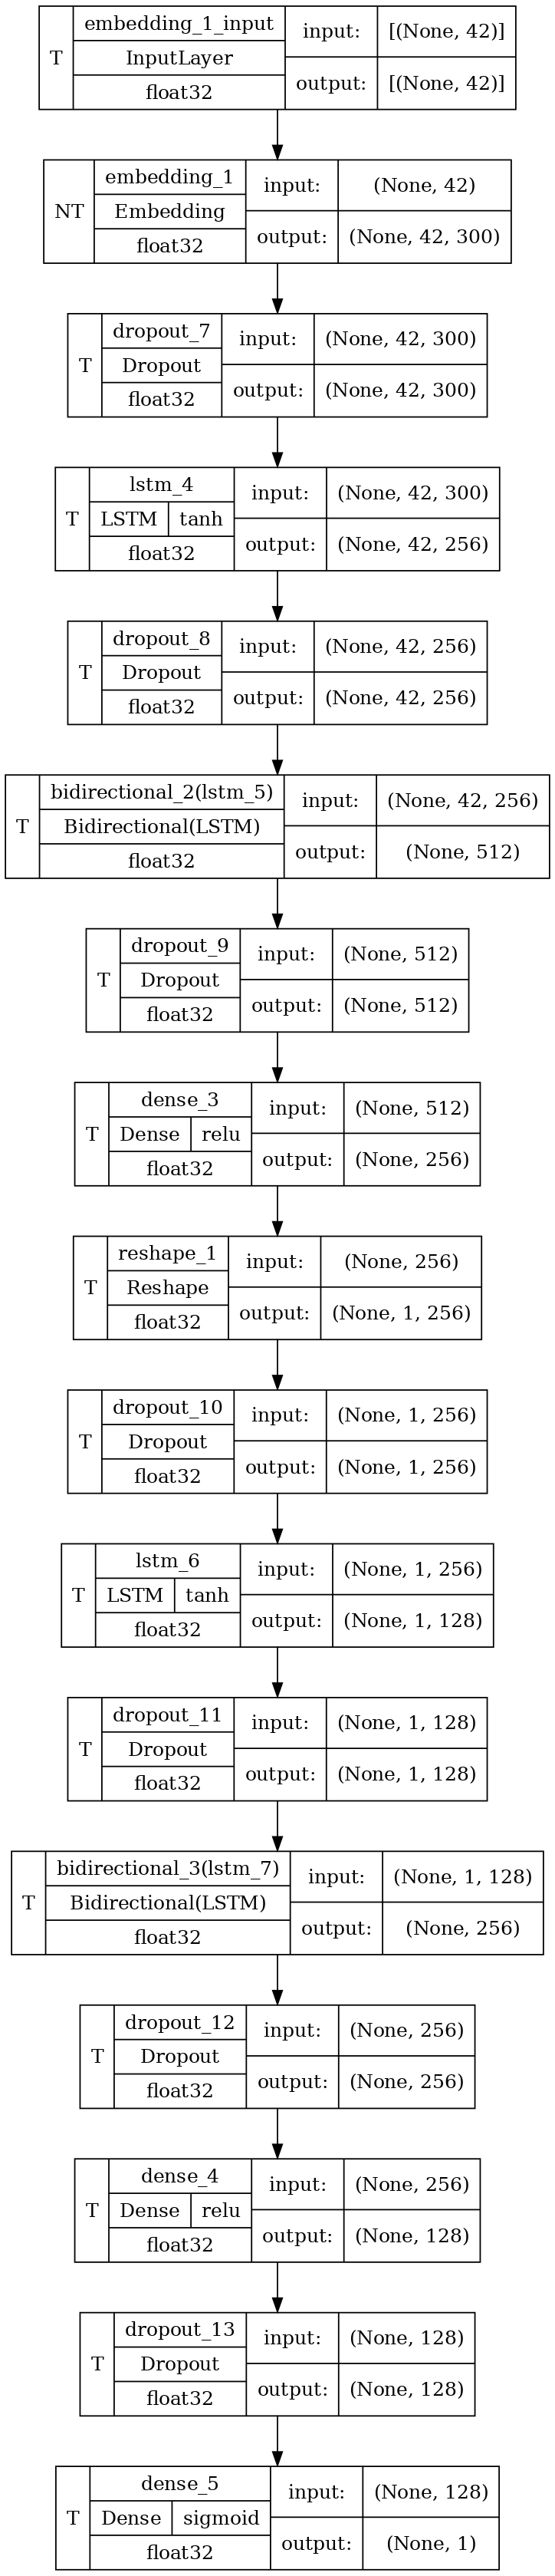

In [44]:
model.summary()

tf.keras.utils.plot_model(
model,
to_file='model.png',
show_shapes=True,
show_dtype=True,
show_layer_names=True,
rankdir='TB',
expand_nested=True,
dpi=128,
layer_range=None,
show_layer_activations=True,
show_trainable=True
)

### Design Choices

***After quite a few training runs I settled on a RNN which includes several LSTM, GRU, and Bi-Directional layers. Each with larger number of inputs to start and then decreasing as the model goes deeper. I originally started with this technique in reverse wherein I started with smaller input sized layers and increased with depth and after trying both ways I got a slight boost in performance by shrinking the input sizes at each depth.***

***I also included some dense layers to give the model more information to learn from throughout the RNN.***

***I used dropout at regular intervals for two reasons. The first reason is when we freeze a portion of the weights during training we force the model to optimize with fewer parameters which typically leads to better generalization and robustness on unseen test data. Also freezing some weights means we do not have to perform gradient descent on that proportion of the weights meaning training time will be reduced. This allows for more experiments in less time.***

***Using a large pre-trained embedding model also helped with performance. I originally started with the GLoVe 100d model and then upgraded to the 300d which increases the models abiliity to learn by a large amount.***

***Using an learning rate optimizer(ADAM in this case) helped to converge faster and helped me complete more experiments in shorter amount of time as well.***

***Batch size during training had an enourmous impact on the performance of the model and the ability to learn the training data. Because the amount of training data was so small and we are using such a large model we really need to be careful and not chunk the data too largely as the model will not learn much during the training process. I settled on a batch size of 4 which by most larger data set sizes would be too small but in the case of this data, it worked out nicely.***

# Evaluation

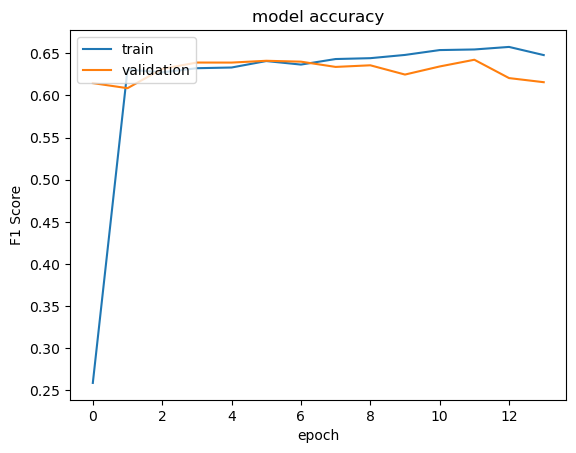

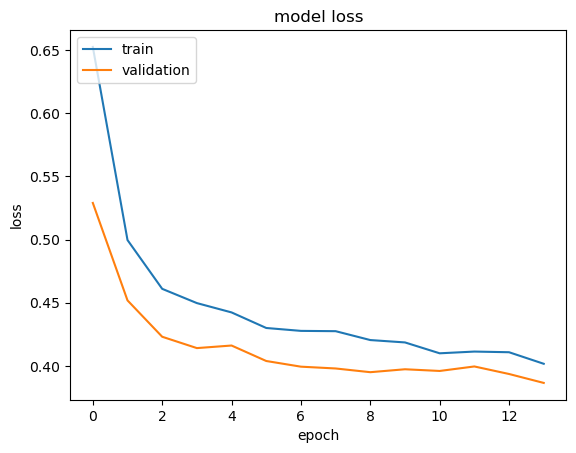

In [45]:
# model.evaluate_generator(generator=validation_generator)

# summarize history for accuracy
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# Save the model
model.save('Keras_RNN_3.h5')  

# Inference

In [46]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

## Predict on test set
with tf.device('/GPU:0'):
    model = load_model('/kaggle/working/Keras_RNN_3.h5', custom_objects={'f1_score': f1_score})
    y_pred = model.predict(test)


submission['target'] = np.round(y_pred).astype('int')
submission.to_csv('submission.csv', index=False)

102/102 [==============================] - 3s 7ms/step


In [47]:
submission.sample(6)

,id,target
3083,10216,0
1738,5862,1
66,223,1
1391,4586,1
2627,8794,0
2415,8077,1
